Using device: cpu
Train Branch Repeated Shape: (10000, 16384)
Train Trunk Sampled Shape: (10000, 2)
Train Target Flat Shape: (10000, 4096)
Test Branch Repeated Shape: (3000, 16384)
Test Trunk Sampled Shape: (3000, 2)
Test Target Flat Shape: (3000, 4096)
Compiling model...
'compile' took 0.000347 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [3.04e-01]    [2.93e-01]    [8.88e-01]    
1         [3.17e+02]    [3.13e+02]    [2.90e+01]    
2         [1.70e+01]    [1.68e+01]    [6.72e+00]    
3         [3.77e-01]    [3.74e-01]    [1.00e+00]    
4         [3.79e-01]    [3.77e-01]    [1.01e+00]    
5         [3.82e-01]    [3.79e-01]    [1.01e+00]    
6         [3.84e-01]    [3.81e-01]    [1.01e+00]    
7         [3.85e-01]    [3.82e-01]    [1.01e+00]    
8         [3.86e-01]    [3.84e-01]    [1.02e+00]    
9         [3.87e-01]    [3.84e-01]    [1.02e+00]    
10        [3.88e-01]    [3.85e-01]    [1.02e+00]    
11        [3.88e-01]    [3.86e-01]    [1.02e+

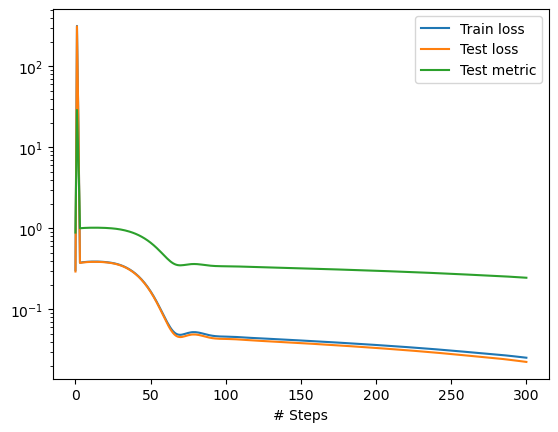

Test error: 0.24541392922401428


ValueError: cannot reshape array of size 3000 into shape (30,100,64,64)

In [13]:
import deepxde as dde
import numpy as np
import h5py
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn.init as init  # Ensure initializer is imported
from deepxde.callbacks import Callback

# ====================================
# Define Device (CUDA if available)
# ====================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ====================================
# Function to Load and Preprocess Data
# ====================================
def load_and_preprocess(hdf5_filepath, input_dim):
    with h5py.File(hdf5_filepath, 'r') as f:
        # Read datasets
        tempIon_data = f['tempIon_data'][:]
        denIon_data = f['denIon_data'][:]
        tempElc_data = f['tempElc_data'][:]
        denElc_data = f['denElc_data'][:]
        phi_data = f['phi_data'][:]
        times = f['times'][:]
        grid = f['grid'][:]
        
        # Read attributes
        Nx = f.attrs['Nx']
        Ny = f.attrs['Ny']
        Nt = f.attrs['Nt']

    # Convert to tensors with dtype float32
    denIon_tensor = torch.tensor(denIon_data, dtype=torch.float32)
    tempElc_tensor = torch.tensor(tempElc_data, dtype=torch.float32)
    tempIon_tensor = torch.tensor(tempIon_data, dtype=torch.float32)
    denElc_tensor = torch.tensor(denElc_data, dtype=torch.float32)
    phi_tensor = torch.tensor(phi_data, dtype=torch.float32)
    
    # Stack all fields for consistent rescaling
    combined_fields = torch.stack(
        (denIon_tensor, tempElc_tensor, tempIon_tensor, denElc_tensor, phi_tensor), dim=-1
    )
    global_min = torch.min(combined_fields)
    global_max = torch.max(combined_fields)
    combined_fields = (combined_fields - global_min) / (global_max - global_min)
    
    # Separate input fields and target field
    input_fields = combined_fields[..., :-1]  # All but the last channel
    phi_normalized = combined_fields[..., -1]  # Last channel is the target
    
    # Resize input fields and target field
    input_fields_resized = torch.zeros(
        (combined_fields.shape[0], input_dim, input_dim, 4), dtype=torch.float32
    )
    phi_resized = torch.zeros(
        (combined_fields.shape[0], input_dim, input_dim), dtype=torch.float32
    )
    
    for i in range(4):
        # Resize each input field channel
        input_fields_resized[..., i] = F.interpolate(
            input_fields[..., i].unsqueeze(1),  # Add channel dimension
            size=(input_dim, input_dim),
            mode='bilinear',
            align_corners=False
        ).squeeze(1)  # Remove channel dimension
    
    # Resize target field
    phi_resized = F.interpolate(
        phi_normalized.unsqueeze(1),
        size=(input_dim, input_dim),
        mode='bilinear',
        align_corners=False
    ).squeeze(1)
    
    # Flatten the resized inputs
    branch_inputs = input_fields_resized.view(combined_fields.shape[0], -1)  # Shape: (num_samples, 4*input_dim*input_dim)
    phi_flat = phi_resized.view(combined_fields.shape[0], -1)  # Shape: (num_samples, input_dim*input_dim)
    
    # Create trunk grid (coordinates)
    x_coords = np.linspace(0, 1, input_dim, dtype=np.float32)  # Ensure float32
    y_coords = np.linspace(0, 1, input_dim, dtype=np.float32)  # Ensure float32
    X, Y = np.meshgrid(x_coords, y_coords)
    trunk_grid = np.stack([X.flatten(), Y.flatten()], axis=1).astype(np.float32)  # Shape: (input_dim^2, 2)
    
    return branch_inputs.numpy(), trunk_grid, phi_flat.numpy()

# ====================================
# Load and Preprocess Data
# ====================================
input_dim = 64  # Adjust based on your system's memory capacity
hdf5_filepath = '/Users/iangill/Downloads/test_MuSHrooM_all_fields_small.h5'

branch_inputs, trunk_grid, phi_flat = load_and_preprocess(hdf5_filepath, input_dim)

# ====================================
# Split the Data into Training and Test Sets
# ====================================
ntrain = 100
ntest = 30  # Adjust based on your dataset

# Total samples
total_samples = branch_inputs.shape[0]
assert ntrain + ntest <= total_samples, "Not enough samples in the dataset."

# Shuffle the data indices
indices = np.arange(total_samples)
np.random.shuffle(indices)

# Split the data
train_indices = indices[:ntrain]
test_indices = indices[ntrain:ntrain + ntest]

train_branch = branch_inputs[train_indices]
train_target = phi_flat[train_indices]

test_branch = branch_inputs[test_indices]
test_target = phi_flat[test_indices]

# ====================================
# Sample a Fixed Number of Trunk Inputs per Branch Input
# ====================================
k = 100  # Number of trunk samples per branch input

def sample_trunk_inputs(trunk_grid, k):
    """
    Randomly sample k trunk inputs from the trunk_grid.
    """
    total_trunk = trunk_grid.shape[0]
    if k > total_trunk:
        raise ValueError(f"k={k} cannot be greater than the total number of trunk inputs ({total_trunk}).")
    sampled_indices = np.random.choice(total_trunk, size=k, replace=False)
    return trunk_grid[sampled_indices]

# Sample trunk inputs for training
train_trunk_sampled = np.array([sample_trunk_inputs(trunk_grid, k) for _ in range(ntrain)])
train_trunk_sampled = train_trunk_sampled.reshape(-1, 2)  # Shape: (ntrain * k, 2)

# Sample trunk inputs for testing
test_trunk_sampled = np.array([sample_trunk_inputs(trunk_grid, trunk_grid.shape[0]) for _ in range(ntest)])
test_trunk_sampled = test_trunk_sampled.reshape(-1, 2)    # Shape: (ntest * k, 2)

# Repeat branch inputs k times for each sampled trunk input
train_branch_repeated = np.repeat(train_branch, k, axis=0)   # Shape: (ntrain * k, branch_input_size)
test_branch_repeated = np.repeat(test_branch, k, axis=0)     # Shape: (ntest * k, branch_input_size)

# Repeat targets k times
train_target_flat = np.repeat(train_target, k, axis=0)       # Shape: (ntrain * k, input_dim*input_dim)
test_target_flat = np.repeat(test_target, k, axis=0)         # Shape: (ntest * k, input_dim*input_dim)

# Verify Shapes
print("Train Branch Repeated Shape:", train_branch_repeated.shape)  # Expected: (ntrain * k, 16384)
print("Train Trunk Sampled Shape:", train_trunk_sampled.shape)      # Expected: (ntrain * k, 2)
print("Train Target Flat Shape:", train_target_flat.shape)          # Expected: (ntrain * k, 4096)

print("Test Branch Repeated Shape:", test_branch_repeated.shape)    # Expected: (ntest * k, 16384)
print("Test Trunk Sampled Shape:", test_trunk_sampled.shape)        # Expected: (ntest * k, 2)
print("Test Target Flat Shape:", test_target_flat.shape)            # Expected: (ntest * k, 4096)

# ====================================
# Create DeepXDE's Triple Data Object
# Ensure that the branch inputs are first and trunk inputs second
X_train_final = (train_branch_repeated, train_trunk_sampled)  # Tuple: (branch_input, trunk_input)
y_train_final = train_target_flat

X_test_final = (test_branch_repeated, test_trunk_sampled)     # Tuple: (branch_input, trunk_input)
y_test_final = test_target_flat

# Define the Triple data object with correct ordering
data = dde.data.Triple(
    X_train=X_train_final,   # (branch_input, trunk_input)
    y_train=y_train_final,
    X_test=X_test_final,     # (branch_input, trunk_input)
    y_test=y_test_final
)

# Define the Triple data object with correct ordering
data = dde.data.Triple(
    X_train=X_train_final,   # [branch_input, trunk_input]
    y_train=y_train_final,
    X_test=X_test_final,     # [branch_input, trunk_input]
    y_test=y_test_final
)
# ====================================
# Proceed with Model Definition and Training
# ====================================

# You can now proceed to define your DeepONet model, compile it, and train as follows:

# Define the DeepONet Model
branch_input_size = branch_inputs.shape[1]  # 4 * 64 * 64 = 16384
trunk_input_size = 2  # (x, y) coordinates

net = dde.maps.DeepONet(
    layer_sizes_branch=[branch_input_size, 128, 128],
    layer_sizes_trunk=[trunk_input_size, 128, 128],
    activation="relu",
    kernel_initializer=init.xavier_uniform_,
)

# Define a Custom Callback to Print Training Progress


# Move the Model to CUDA
net.to(device)

# Define the Model
model = dde.Model(data, net)

# Compile the Model
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

# Train the Model
print_callback = PrintCallback()

losshistory, train_state = model.train(
    iterations=300,
    display_every=1
)

# Plot the Training History
dde.utils.plot_loss_history(losshistory)
plt.show()

# Evaluate the Model on Test Data
# Predictions on the test set
y_pred_test = model.predict(X_test_final)
y_test_flat = y_test_final

# Calculate test error
test_error = dde.metrics.l2_relative_error(y_test_flat, y_pred_test)
print(f"Test error: {test_error}")

# Visualization
# Reshape predictions and true values for visualization
pred_phi = y_pred_test.reshape(ntest, k, input_dim, input_dim)
true_phi = y_test_flat.reshape(ntest, k, input_dim, input_dim)

# For visualization, select a sample branch and a specific trunk input
# Here, we'll visualize the first trunk input across all test samples
sample_trunk_index = 0  # Change this index to view different trunk inputs

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(pred_phi[:, sample_trunk_index].mean(axis=0), cmap="jet", origin="lower")
plt.colorbar()
plt.title("Predicted Phi (Averaged across Trunk Inputs)")

plt.subplot(1, 2, 2)
plt.imshow(true_phi[:, sample_trunk_index].mean(axis=0), cmap="jet", origin="lower")
plt.colorbar()
plt.title("True Phi (Averaged across Trunk Inputs)")

plt.show()